In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
#import required packages

import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData
import skmisc

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp

/tmp/ipykernel_2784570/3606276056.py:20: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [24]:
#install required bioconductor and github packages
bioc = ro.packages.importr('BiocManager') 
remotes = ro.packages.importr('remotes')
utils = ro.packages.importr('utils')
utils.chooseCRANmirror(ind=1)

bioc.install('scran')
bioc.install('BiocParallel')
bioc.install('scry')

remotes.install_github('carmonalab/STACAS') #for integration based on MNNs
remotes.install_github('carmonalab/ProjecTILs') #for annotating Tcell subtypes
bioc.install('UCell')
utils.install_packages('scGate')#for celltype annotation

* installing *source* package ‘UCell’ ...
** using staged installation
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (UCell)


Update all/some/none? [a/s/n]: 

* installing *source* package ‘curl’ ...
** Paket ‘curl’ erfolgreich entpackt und MD5 Summen überprüft
** using staged installation


Found pkg-config cflags and libs!
Using PKG_CFLAGS=-I/usr/include/x86_64-linux-gnu
Using PKG_LIBS=-lcurl
--------------------------- [ANTICONF] --------------------------------
Configuration failed because libcurl was not found. Try installing:
 * deb: libcurl4-openssl-dev (Debian, Ubuntu, etc)
 * rpm: libcurl-devel (Fedora, CentOS, RHEL)
If libcurl is already installed, check that 'pkg-config' is in your
PATH and PKG_CONFIG_PATH contains a libcurl.pc file. If pkg-config
is unavailable you can set INCLUDE_DIR and LIB_DIR manually via:
R CMD INSTALL --configure-vars='INCLUDE_DIR=... LIB_DIR=...'
-------------------------- [ERROR MESSAGE] ---------------------------
In file included from /home/s377963/mambaforge/envs/scanpy/x86_64-conda-linux-gnu/sysroot/usr/include/features.h:375,
                 from /usr/include/x86_64-linux-gnu/sys/types.h:25,
                 from /usr/include/x86_64-linux-gnu/curl/system.h:430,
                 from /usr/include/x86_64-linux-gnu/curl/curl.h:35,
  

ERROR: configuration failed for package ‘curl’
* removing ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library/curl’
* restoring previous ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library/curl’
ERROR: failed to lock directory ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library’ for modifying
Try removing ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library/00LOCK-data.table’
ERROR: failed to lock directory ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library’ for modifying
Try removing ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library/00LOCK-igraph’
ERROR: failed to lock directory ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library’ for modifying
Try removing ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library/00LOCK-matrixStats’
* installing *source* package ‘rstudioapi’ ...
** Paket ‘rstudioapi’ erfolgreich entpackt und MD5 Summen überprüft
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying f

x86_64-conda-linux-gnu-cc -I"/home/s377963/mambaforge/envs/scanpy/lib/R/include" -DNDEBUG -I../inst/include/  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/s377963/mambaforge/envs/scanpy/include -I/home/s377963/mambaforge/envs/scanpy/include -Wl,-rpath-link,/home/s377963/mambaforge/envs/scanpy/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/s377963/mambaforge/envs/scanpy/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1723488709275/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/home/s377963/mambaforge/envs/scanpy=/usr/local/src/conda-prefix  -c bbox-handler.c -o bbox-handler.o
x86_64-conda-linux-gnu-cc -I"/home/s377963/mambaforge/envs/scanpy/lib/R/include" -DNDEBUG -I../inst/include/  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/s377963/mambaforge/envs/scanpy/include -I/home/s377963/mambaforge/envs/scanpy/include -Wl,-rpath-link,/home/s377

installing to /home/s377963/mambaforge/envs/scanpy/lib/R/library/00LOCK-wk/00new/wk/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (wk)
ERROR: failed to lock directory ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library’ for modifying
Try removing ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library/00LOCK-spatstat.random’
ERROR: failed to lock directory ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library’ for modifying
Try removing ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library/00LOCK-spatstat.explore’
* installing *source* package ‘scGate’ ...
** Paket ‘scGate’ erfolgr

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f1dc1503890> [0]

In [ ]:
#import required R packages
soupx = ro.packages.importr('SoupX') 
scran = ro.packages.importr('scran') 
bcp = ro.packages.importr('BiocParallel') 
scry = ro.packages.importr('scry')
stacas = ro.packages.importr('STACAS')
seurat = ro.packages.importr('Seurat')
scgate = ro.packages.importr('scGate')
Matrix = ro.packages.importr('Matrix')
ProjecTILs = ro.packages.importr('ProjecTILs')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

### 1. Import all the data

In [363]:
path_to_folders = './01_data/raw/cellranger_multi'
path_to_count_matrices_in_folders = 'per_sample_outs/count/sample_filtered_feature_bc_matrix'
path_to_raw_count_matrices_in_folders = 'count/raw_feature_bc_matrix'

adatas = dp.read_all_pools(path_to_folders, path_to_count_matrices_in_folders)
adatas_raw = dp.read_all_pools(path_to_folders, path_to_raw_count_matrices_in_folders)

Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P1_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P2_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P3_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P4_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P5_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P6_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P7_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellra

### 2. Transfer HTOs from count to obs column to avoid influence on SoupX and quality control

In [364]:
import importlib
importlib.reload(dp)

<module 'functions_dat_processing' from '/home/s377963/car_t_sc/02_code/functions/functions_dat_processing.py'>

In [365]:
hto_and_adata_list = [dp.generate_hto_adata_object(adata, rename=True) for adata in adatas]
zipped = list(zip(*hto_and_adata_list))
adata_htos = zipped[0]
adata_nohtos = zipped[1]

In [ ]:
for adata, adata_hto in zip(adata_nohtos, adata_htos):
    #import data
    %R -i adata -i adata_hto
    #convert dgRMatrix to dgCMatrix
    %R assay(adata_hto, 'X') <- as(as.matrix(assay(adata_hto, 'X')), 'dgCMatrix')
    %R assay(adata, 'X') <- as(as.matrix(assay(adata, 'X')), 'dgCMatrix')
    #convert to seurat object
    %R adata_seurat <- CreateSeuratObject(counts = assay(adata, 'X'))
    #create HTO assay
    %R adata_seurat[["HTO"]] <- CreateAssayObject(counts = assay(adata_hto, 'X') + 1) #+1 adds a small pseudocount to avoid clusters with cells containing only 0 counts for a given HTO
    #normalize hto counts
    %R adata_seurat <- NormalizeData(adata_seurat, assay = "HTO", normalization.method = "CLR")
    #Demultiplex using HTODemux
    %R adata_seurat <- HTODemux(adata_seurat, assay = "HTO", positive.quantile = 0.99, kfunc = 'kmeans')
    #define classification and assign cells to it
    %R sample_class <- adata_seurat$HTO_classification
    %R sample_class_global <- adata_seurat$HTO_classification.global
    %R -o sample_class
    %R -o sample_class_global
    adata.obs['specific_class'] = sample_class
    adata.obs['Classification'] = sample_class_global
    adatas_singlets = [dp.filter_for_singlets(adata) for adata in adata_nohtos]

  |                                                  | 0 % ~calculating   |+++++++++++++++++                                 | 33% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  
  |                                                  | 0 % ~calculating   |+++++++++                                         | 17% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  
  |                                                  | 0 % ~calculating   |+++++++++                                         | 17% ~00s           |+++++++++++++++++                                 | 33% ~

In [ ]:
#this is the preprocessing fo hashsolo, which is used only after soupX and QC, the above used HTODemux is used prior to SoupX and QC
adatas2, adatas_raw2, conditions = dp.transfer_htos(adatas, adatas_raw)

### 3. perform quality control

In [379]:
# adatas_mad = dp.quality_control(adatas_singlets)
# adatas_qc = dp.quality_control(adatas_singlets)
# adatas_qc = dp.quality_control(adatas_singlets, method = 'qntl')
adatas_qc = dp.quality_control(adatas_singlets, method = 'abs')

computing qc for Pool 1
computing qc for Pool 2
computing qc for Pool 3
computing qc for Pool 4
computing qc for Pool 5
computing qc for Pool 6
computing qc for Pool 7
computing qc for Pool 8
computing qc for Pool 9


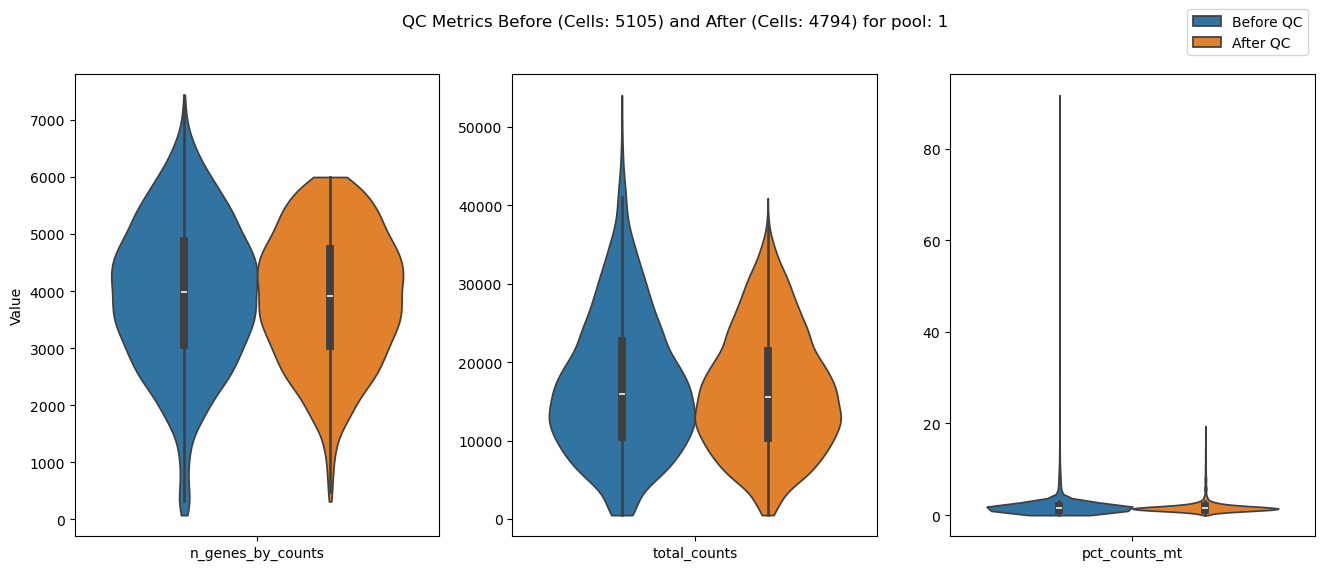

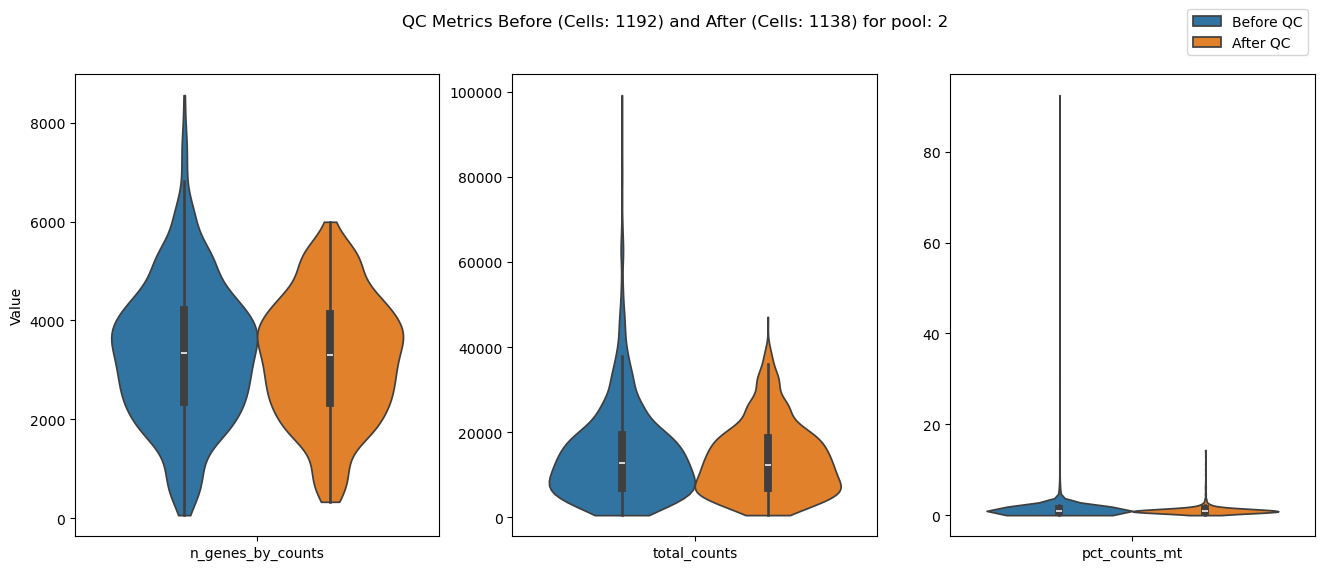

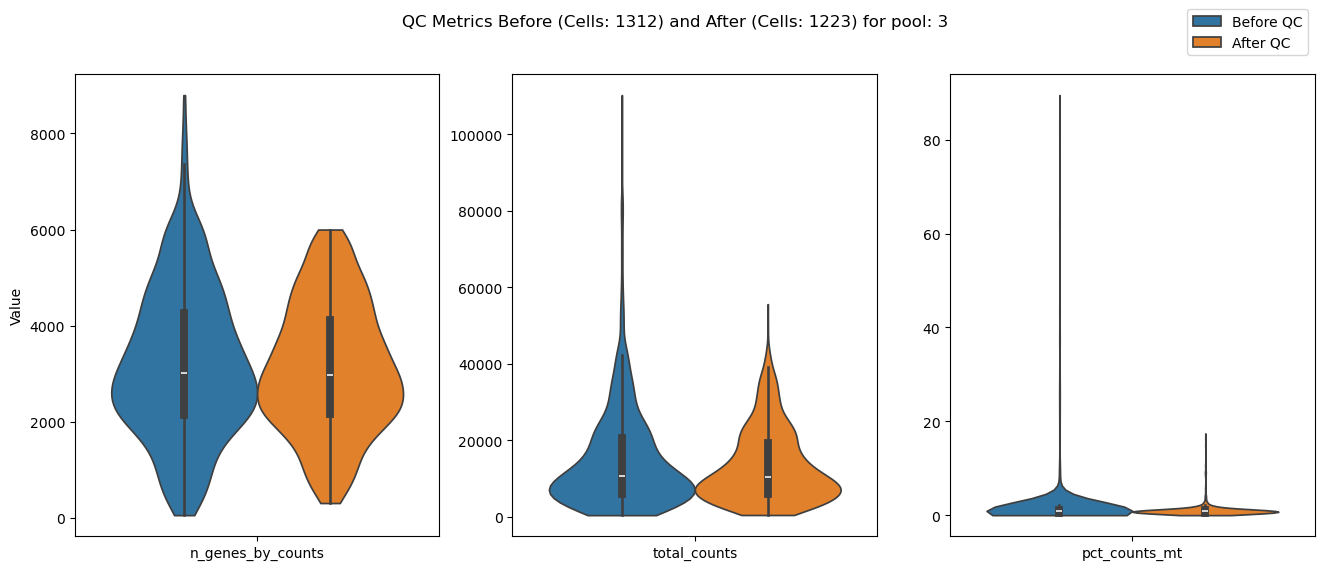

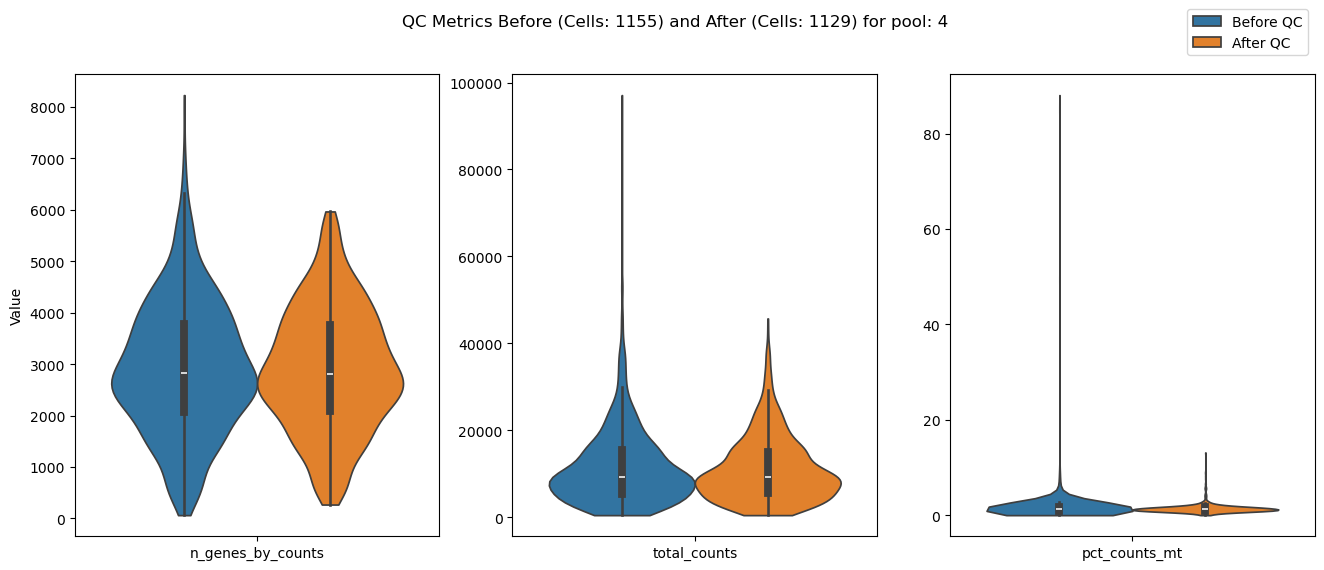

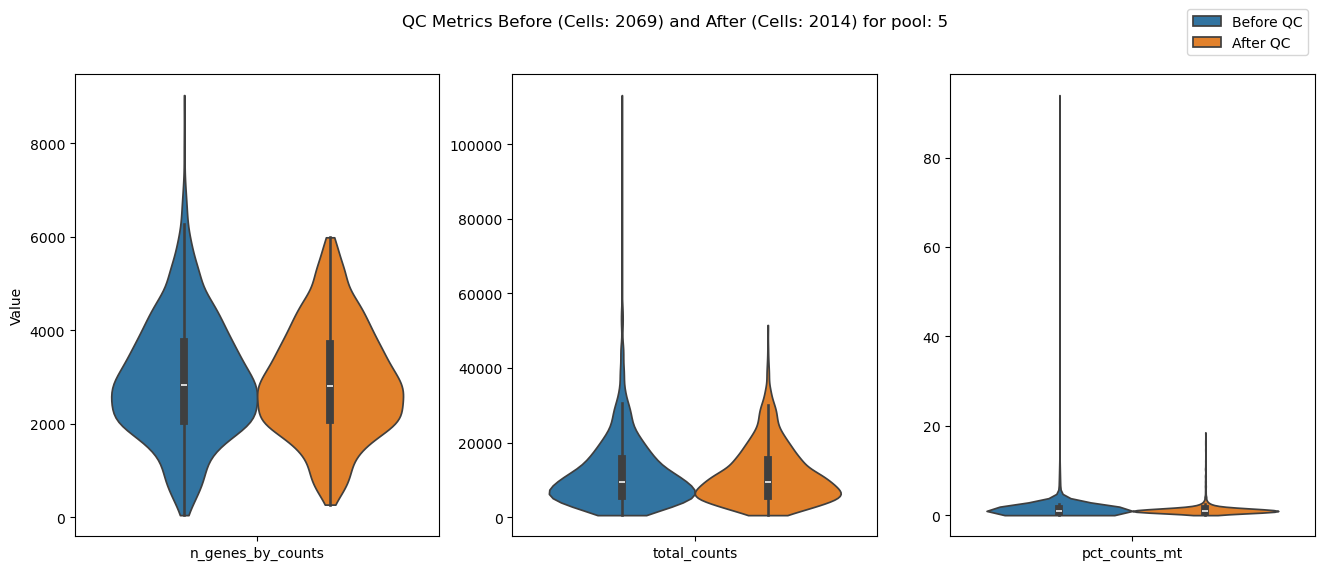

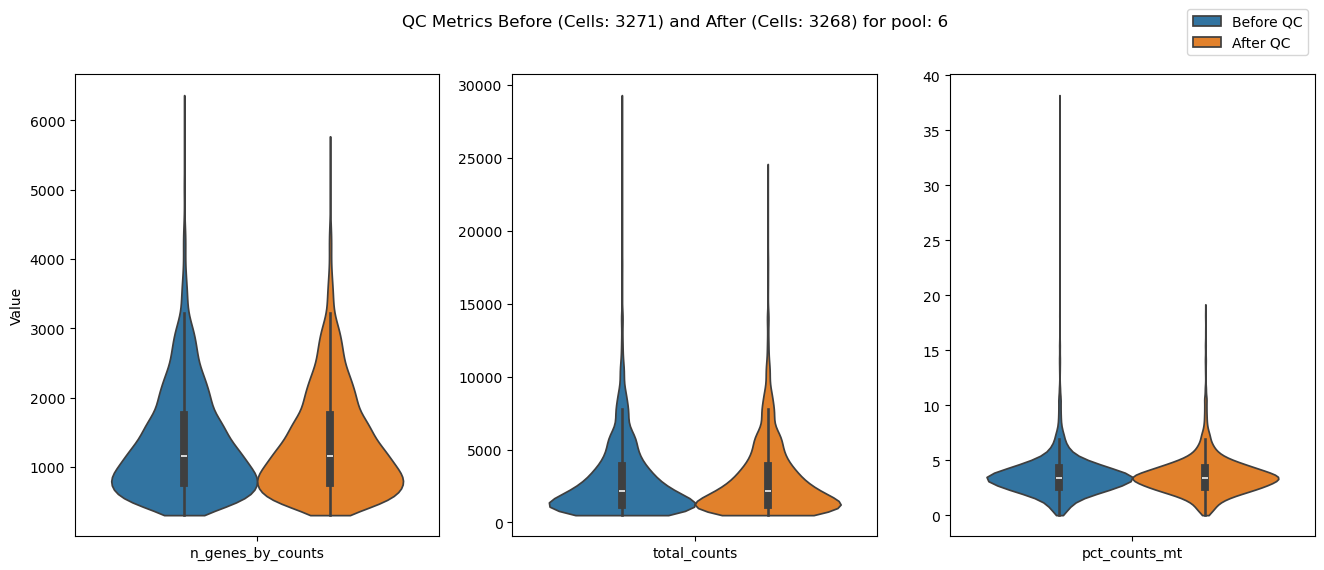

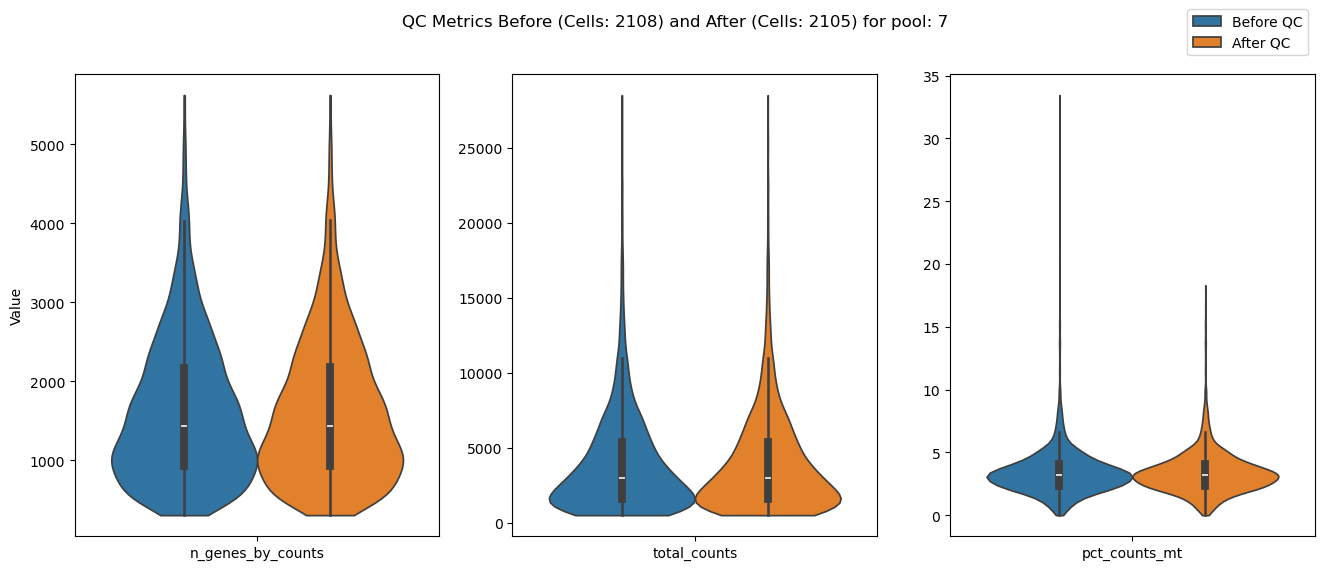

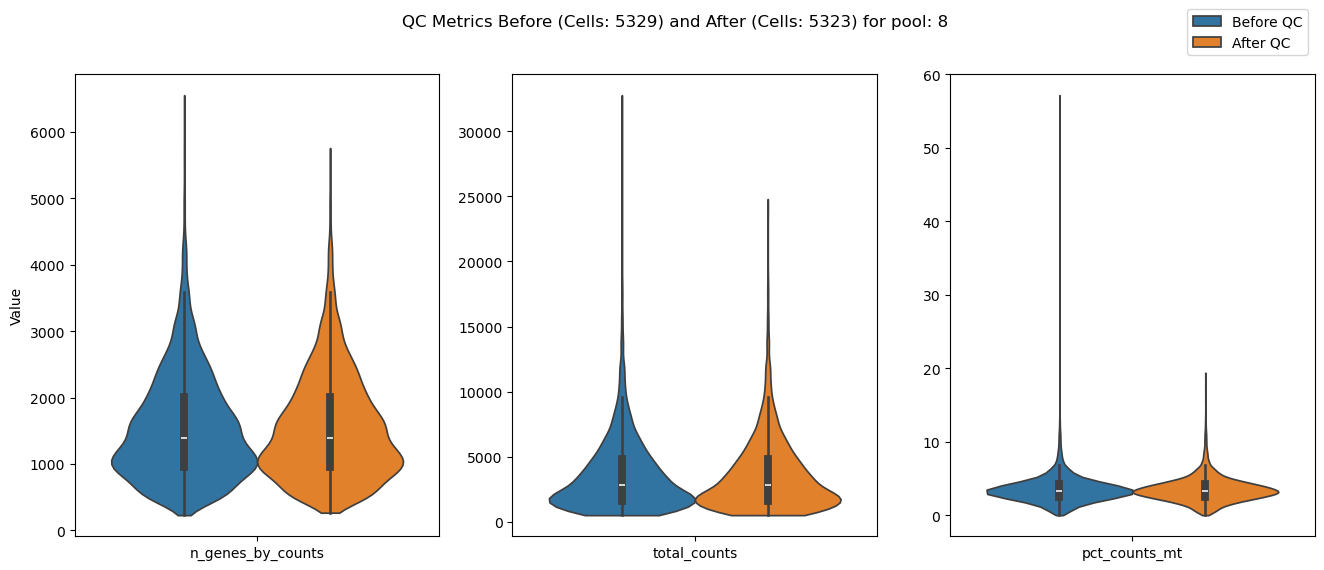

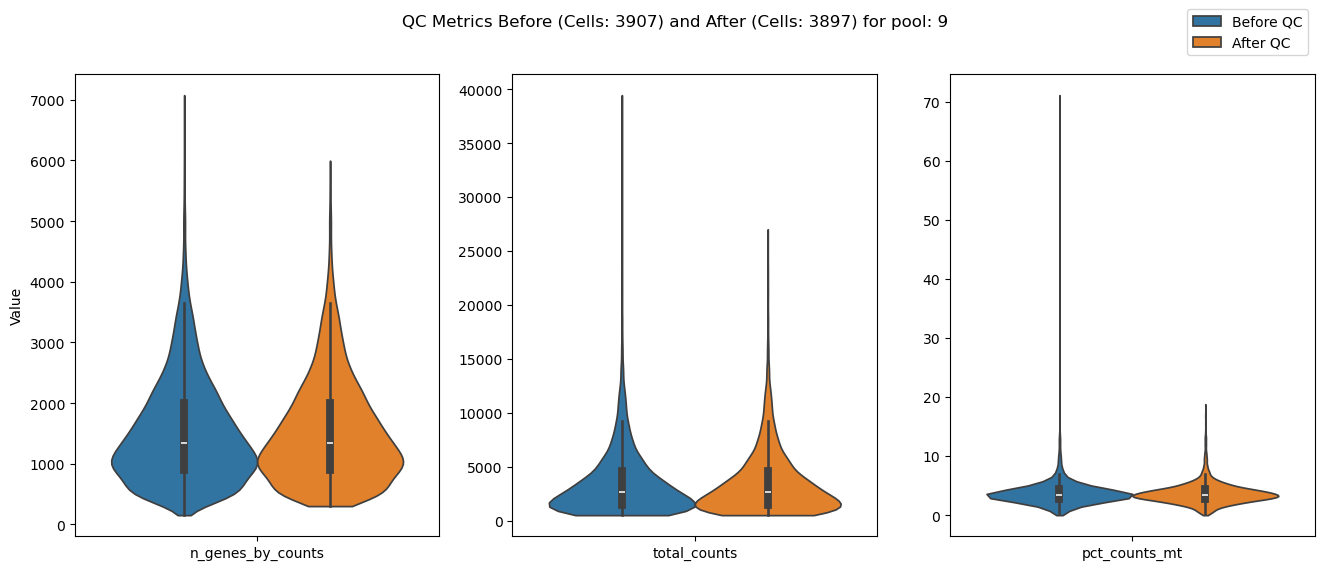

In [ ]:
dp.plot_qc_metrics(adatas_singlets, adatas_qc)

In [385]:
adatas_singlets = adatas_qc

In [386]:
sum([adata.shape[0] for adata in adatas_singlets])

24891

### 4. Perform SoupX to correct for ambient mRNA

In [9]:
groups = [dp.pregroup(adata) for adata in adatas]
adatas = [dp.cook_soup(adata, adata_raw, group) for (adata, adata_raw, group) in zip(adatas, adatas_raw, groups)]

### 5. Demultiplex the data using hashsolo (needs to be after qc since its based on priot probabilities that assume cells have passed filtering. Also, reasonable after SoupX, since filtering out doublets etc. will affect the soupx clusters)

In [ ]:
dp.demultiplex(adatas, conditions)
adatas = [dp.filter_for_singlets(adata) for adata in adatas]

### 6. Concatenate/merge all the pools

In [394]:
#merge andata objects, do not include genes that are not present in all samples (join = 'inner'), set to join = 'outer' if wanting to retain all genes if present in at least one dataset
adata_merged = ad.concat(adatas_singlets, join='inner', label='dataset',index_unique='_')

#there are about 200 dLN cells left after using hashsolo with absolute QC, however there are around 6000 left when using HTODemux
adata_merged = adata_merged[ adata_merged.obs['specific_class'].str.contains('d0')| adata_merged.obs['specific_class'].str.contains('TIL')].copy()

### 7. Normalize the data using shifter logarithm or scran normalization

In [397]:
scales_counts = sc.pp.normalize_total(adata_merged, target_sum=1e4, inplace=False)
adata_merged.layers['log1p'] = sc.pp.log1p(scales_counts["X"], copy=True)

In [39]:
groups = dp.pregroup(adata_merged, resolution=15)
adata_merged.layers['scran'] = dp.scran_norm(adata_merged, groups)

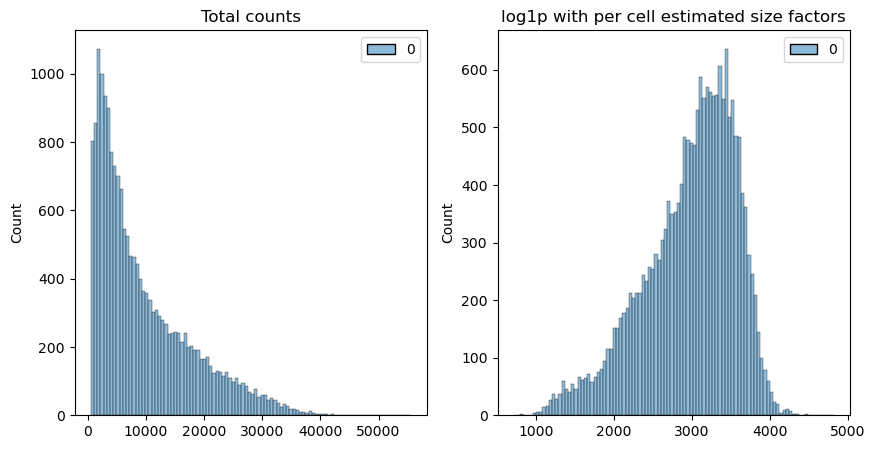

In [398]:
dp.plot_normalization(adata_merged, 'log1p', 'per cell')
# dp.plot_normalization(adata_merged, 'scran', 'scran')

In [399]:
#since scran does not really effectively normalize, we use the shifted logarithm
adata_merged.layers['counts'] = adata_merged.X
adata_merged.X = adata_merged.layers['log1p']

### 8. Perform feature selection

In [ ]:
#select only the 2000 most variable genes in a batch aware way (meaning first in each batch 2000 most variable genes are selected and the 2000 genes that are variable in the most datasets are retained)
sc.pp.highly_variable_genes(adata_merged, n_top_genes=3000, flavor="seurat", batch_key='dataset')

#subset merged data based on highly variable genes 
adata_merged_hvg = adata_merged[:, adata_merged.var.highly_variable].copy()

#store the genes selected by the hvg function for later use during integration
anchor_features = adata_merged_hvg.var_names.values
ro.globalenv["anchor_features"] = anchor_features

In [400]:
######
#alternatively with seurat, this yields about 60% the same genes, so its slightly different in selecting variale features, however the end result is extremely similar:
######
#first make the concatenated/merged data available to R 
adata_merged_seurat = adata_merged.copy()
adata_merged_seurat.obs['dataset'] = adata_merged_seurat.obs['dataset'].astype(str)
del adata_merged_seurat.uns
ro.globalenv["adata_merged_seurat"] = adata_merged_seurat

#convert from R singleCellObject into a seurat object and split the datasets into a list. Also rename the assay so it will be recognized by all R functions as the original assay
%R seurat <- as.Seurat(adata_merged_seurat, counts = "counts", data = "log1p") #counts = "soupX_counts" or "counts"
%R seurat <- RenameAssays(seurat, originalexp = "RNA")
%R batch_list <- SplitObject(seurat, split.by = "dataset")

#finally select highly variable genes in a batch aware way in seurat
%R seurat_features <- SelectIntegrationFeatures(batch_list, nfeatures=3000, fvf.nfeatures = 3000)
%R -o seurat_features

#subset the data based on the highly variable genes selected
adata_merged_hvg = adata_merged[:, seurat_features].copy()

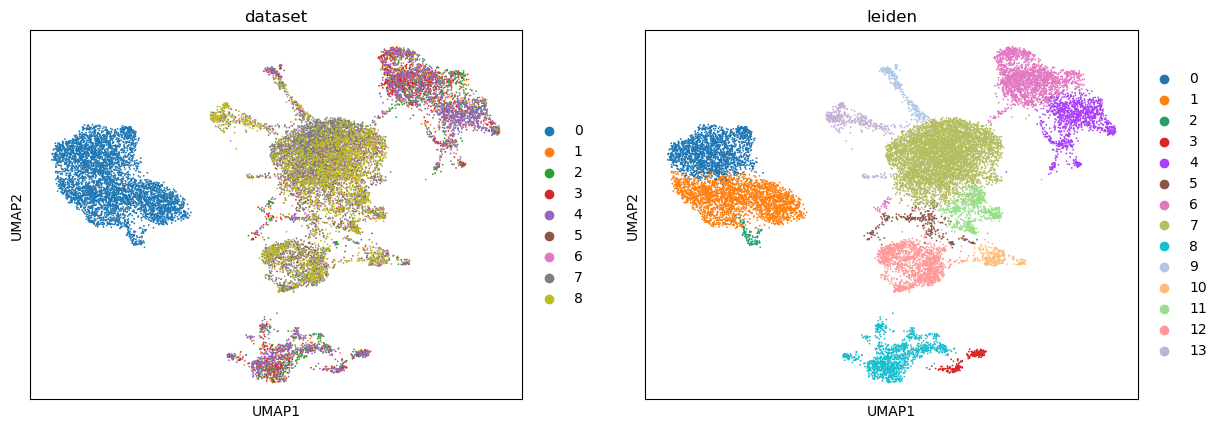

In [401]:
#plot the unintegrated data with coloring the discrete datasets to see their difference
sc.tl.pca(adata_merged_hvg, mask_var=None)
sc.pp.neighbors(adata_merged_hvg)
sc.tl.umap(adata_merged_hvg)
sc.tl.leiden(adata_merged_hvg, resolution=0.4, flavor="igraph" , n_iterations=2)
sc.pl.umap(adata_merged_hvg, color=['dataset', 'leiden'])

### 9. Perform data integration using Mutual Nearest Neighbots (since this is a way to effectively change the count matrix and unlike other integration methods, this yields not only a lower dimensional representation of the data)

In [402]:
#STACAS uses normalized counts, in seurats tutoral, they first do NormalizeData() and use seurat integration afterwards
%R integrated <-  Run.STACAS(batch_list, anchor.features = seurat_features, dims = 1:30) #rownames(seurat) for all features, anchor_features for scanpy version, seurat_features for seurat version

%R integrated_expr <- GetAssayData(integrated)
%R integrated_expr <- t(integrated_expr)
%R -o integrated_expr

adata_merged_hvg.layers['integrated'] = integrated_expr
adata_merged_hvg.X = adata_merged_hvg.layers['integrated']

  |                                                  | 0 % ~calculating   |++++++                                            | 11% ~11s           |++++++++++++                                      | 22% ~05s           |+++++++++++++++++                                 | 33% ~03s           |+++++++++++++++++++++++                           | 44% ~02s           |++++++++++++++++++++++++++++                      | 56% ~01s           |++++++++++++++++++++++++++++++++++                | 67% ~01s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~01s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=03s  
  |                                                  | 0 % ~calculating   |++                                                | 3 % ~03m 05s       |+++                                               | 6 % ~02m 50s       |+++++                                             | 8 % ~02

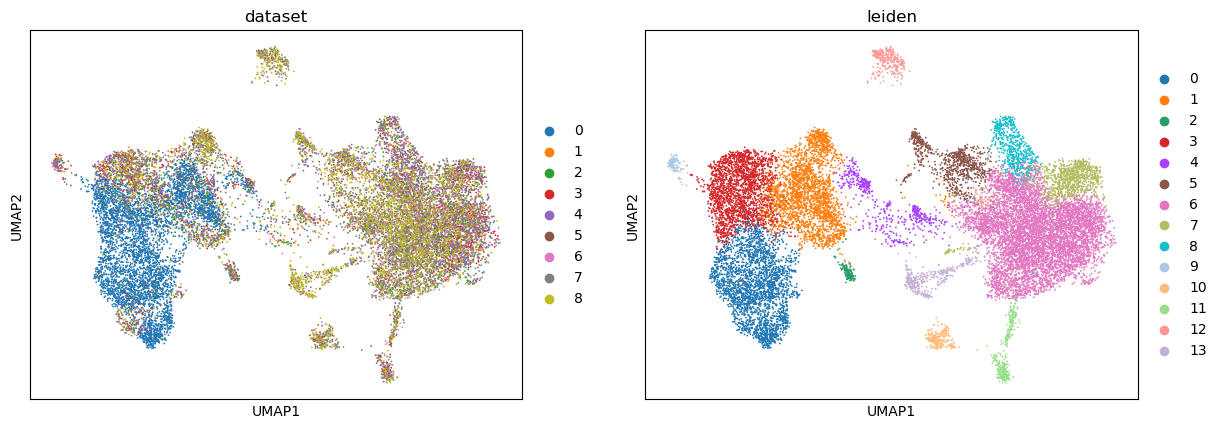

In [403]:
sc.tl.pca(adata_merged_hvg)
sc.pp.neighbors(adata_merged_hvg)
sc.tl.umap(adata_merged_hvg)
sc.tl.leiden(adata_merged_hvg, resolution=0.4, flavor="igraph" , n_iterations=2)
sc.pl.umap(adata_merged_hvg, color=['dataset', 'leiden'])

### 10. Perform Celltype annotation

In [404]:
#using scGate, this is based on the seurat object 'integrated' generated before by stacas. If you are using the integrated matrix from python, you will need to specify the new seurat object and remove reduction = "pca" so that scGate itself generates the pca reduction itself
%R sc_gating_models <- get_scGateDB()
%R seurat_object_annotated <- scGate(integrated, model = sc_gating_models$mouse$generic$Tcell, ncores = 4, reduction = "pca", output.col.name = "is.tcell") #, reduction = 'calculate', assay = 'originalexp'
%R annotation <- seurat_object_annotated@meta.data$is.tcell
%R -o annotation

adata_merged_hvg.obs['is_tcell'] = annotation
sum(adata_merged_hvg.obs.is_tcell == 'Pure')

  |======================================================================| 100%

  |======================================================================| 100%



7532

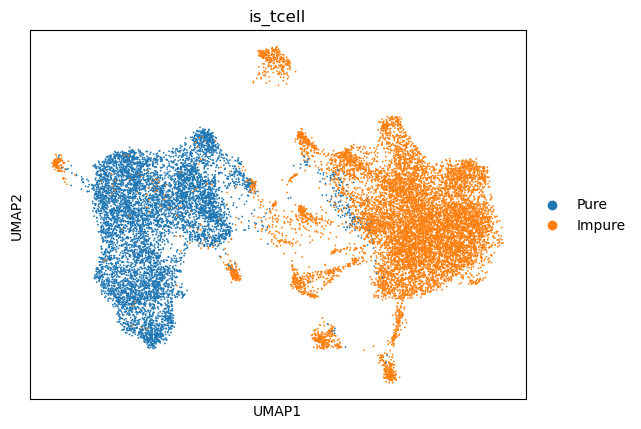

In [405]:
sc.pl.umap(adata_merged_hvg, color='is_tcell')

In [412]:
sum(adata_merged_hvg.obs['is_tcell'] == 'Pure')

7532

In [ ]:
#download the reference datasets to map to
%R download.file("https://figshare.com/ndownloader/files/41414556", destfile = "01_data/reference_datasets_project_TILs/CD8T_human_ref_v1.rds")
%R download.file("https://figshare.com/ndownloader/files/39012395", destfile = "01_data/reference_datasets_project_TILs/CD4T_human_ref_v1.rds")

'value'

In [413]:
%R ref.CD8 <- load.reference.map("01_data/reference_datasets_project_TILs/CD8T_human_ref_v1.rds")
%R ref.CD4 <- load.reference.map("01_data/reference_datasets_project_TILs/CD4T_human_ref_v1.rds")
%R DefaultAssay(ref.CD8) <- "integrated"
%R DefaultAssay(ref.CD4) <- "integrated"

[1] "Loading Custom Reference Atlas..."
[1] "Loaded Custom Reference map Human CD8 TILs"
[1] "Loading Custom Reference Atlas..."
[1] "Loaded Custom Reference map custom_reference"


'value'

In [414]:
adata_pure = adata_merged_hvg[adata_merged_hvg.obs['is_tcell'] == 'Pure']

%R ncores <- 8
%R pure_cells <- subset(seurat_object_annotated, subset = is.tcell == "Pure")
%R DefaultAssay(pure_cells) <- "RNA"
%R pure_cells_CD8 <- ProjecTILs.classifier(query = pure_cells, ref = ref.CD8, ncores = ncores) # , split.by = "dataset" filter.cells = FALSE, skip.normalize=TRUE,
%R pure_cells_CD8_CD4 <- ProjecTILs.classifier(query = pure_cells_CD8, ref = ref.CD4, ncores = ncores, overwrite=FALSE) # , overwrite=FALSE
%R TC_annotations <- pure_cells_CD8_CD4@meta.data$functional.cluster
%R -o TC_annotations 

adata_pure.obs['Tcell_subtype'] = TC_annotations
%R print(table(pure_cells_CD8_CD4$functional.cluster, useNA = "ifany"))

  |                                                                      |   0%[1] "Using assay RNA for query"
[1] "3004 out of 7532 ( 40% ) non-pure cells removed. Use filter.cells=FALSE to avoid pre-filtering"
[1] "Transforming expression matrix into space of orthologs"
[1] "Aligning query to reference map for batch-correction..."
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~08s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=09s  
  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=21s  

Projecting corrected query onto Reference PCA space

Projecting corrected query onto Reference UMAP space
  |======================================================================| 100%

  |                                                                      |   0%[1] "Using assay RNA for query"
[1

/tmp/ipykernel_2784570/511010560.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_pure.obs['Tcell_subtype'] = TC_annotations



CD4.CTL_EOMES   CD4.CTL_Exh  CD4.CTL_GNLY CD4.NaiveLike       CD4.Tfh 
            2           116             1           112           163 
     CD4.Th17      CD4.Treg        CD8.CM        CD8.EM CD8.NaiveLike 
          329           205           473           200            44 
      CD8.TEX      CD8.TPEX          <NA> 
         1499          2312          2076 


'value'

In [ ]:
pure_cells = sum(adata_merged_hvg.obs['is_tcell'] == 'Pure')
not_annotated_cells = sum(pd.isnull(adata_pure.obs.Tcell_subtype))
diff = pure_cells - not_annotated_cells
print(f'Pure Cells: {pure_cells}')
print(f'From which {not_annotated_cells} could not be annotated')
print(f'{diff} were annotated')

Pure Cells: 7532
From which 2076 could not be annotated
So 5456 were annotated


In [418]:
adata_pure

AnnData object with n_obs × n_vars = 7532 × 3000
    obs: 'specific_class', 'Classification', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'dataset', 'leiden', 'is_tcell', 'Tcell_subtype'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'dataset_colors', 'leiden_colors', 'is_tcell_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p', 'counts', 'integrated'
    obsp: 'distances', 'connectivities'

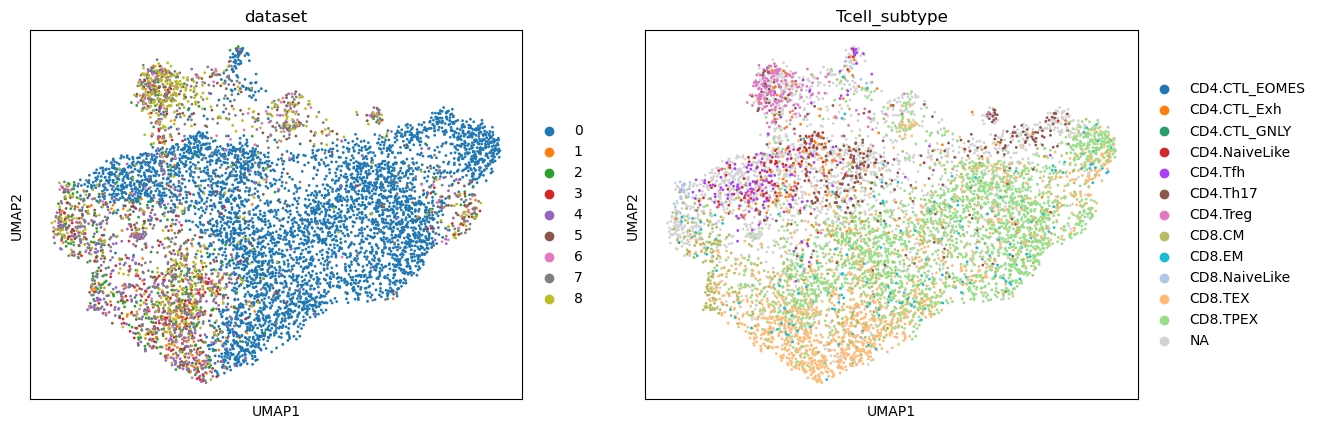

In [419]:
# sc.tl.pca(adata_pure)
# sc.pp.neighbors(adata_pure)
# sc.tl.umap(adata_pure)
# sc.tl.leiden(adata_pure, resolution=0.4, flavor="igraph" , n_iterations=2)
sc.pl.umap(adata_pure, color=['dataset', 'Tcell_subtype'])

### 11. Save the progress

In [46]:
adata_pure.write('01_data/processed/integrated/merged_qc_filtered_abs.h5ad', compression='gzip') #takes forever 

In [420]:
adata = adata_pure.copy()

In [421]:
# adata = sc.read('01_data/processed/integrated/merged_qc_filtered_abs.h5ad')
nas = pd.isna(adata.obs.Tcell_subtype)
adata_nona = adata[~nas,:].copy()

In [433]:
# days = ['d0', 'd7', 'd14']
days = ['0', '7', '14']
conditions = ['C', 'DM', 'P']

def extract_DayCond(days, conditions, classification):
    day = ''.join(filter(lambda day: day in classification, days))
    condition = ''.join(filter(lambda condition: condition in classification, conditions))
    return day, condition

def extract_DaysConds(days, conditions, classifications):
    return [extract_DayCond(days, conditions, classification) for classification in classifications]

def add_DaysConds_to_adata(adata, days, conditions):
    classifications = adata.obs.specific_class.values
    res = extract_DaysConds(days, conditions, classifications)
    cond_days, cond_conds = zip(*res)
    adata.obs['condition'] = cond_conds
    adata.obs['day'] = cond_days

In [434]:
add_DaysConds_to_adata(adata_nona, days, conditions)

In [437]:
def stacked_barplot(adata):
    conditions = np.unique(adata.obs.condition.values)
    days = sorted(np.unique(adata.obs.day), key=lambda x: int(x), reverse=True)
    colors = ['#FF69B4', '#4B0082', '#228B22', '#FFD700', '#4682B4', '#FF4500', '#8B4513']

    # Filter out only CD4 subtypes
    CD4_only = list(map(lambda subtype: 'CD8' in subtype, adata.obs.Tcell_subtype))
    adata = adata[CD4_only, :]
    unq_celltypes = np.unique(adata.obs.Tcell_subtype)

    # Set up subplots for each condition
    fig, axs = plt.subplots(len(conditions), figsize=(8, 6)) #, sharey=True

    # Plot each condition in a separate subplot
    for idx, condition in enumerate(conditions):
        ax = axs[idx] if len(conditions) > 1 else axs  # Handles case with only one condition
        subset = adata[adata.obs.condition == condition, :]
        
        # Initialize dictionary for each celltype's counts by day
        celltype_counts = {celltype: [] for celltype in unq_celltypes}
        
        for celltype in unq_celltypes:
            celltype_subset = subset[subset.obs.Tcell_subtype == celltype, :]
            for day in days:
                day_subset = celltype_subset[celltype_subset.obs.day == day, :]
                day_count = len(day_subset)  # Count the entries for each day and cell type
                celltype_counts[celltype].append(day_count)

        # Normalize cell type counts by day
        norm_factors = [sum(day_counts) for day_counts in zip(*celltype_counts.values())]
        for key, values in celltype_counts.items():
            celltype_counts[key] = (np.array(values) / norm_factors) * 100

        # Stacked bar plot for the current condition
        left = np.zeros(len(days))  # Reset the 'left' offset for each condition
        for i, (celltype, celltype_count) in enumerate(celltype_counts.items()):
            p = ax.barh(days, celltype_count, 0.8, label=celltype, left=left, color=colors[i % len(colors)])
            left += celltype_count
            # ax.bar_label(p, label_type='center', labels=[f'{val:.1f}' for val in celltype_count])
        ax.text(1.05, 0.5, f'Condition: {condition}', transform=ax.transAxes, ha='center', va='center', fontsize=12) #rotation=270,
        if idx == len(conditions) - 1:
            ax.set_xlabel('Percentage')
        else:
            ax.set_xticks([])

        for key, spine in ax.spines.items():
            spine.set_visible(False)

    fig.legend(unq_celltypes, loc='center left', bbox_to_anchor=(1.005, 0.75), title="Cell Types")
    # plt.subplots_adjust(left=0.05, right=0.8, wspace=0.15)
    fig.suptitle('Fraction of CD8 T cells by Condition')
    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit suptitle
    plt.show()

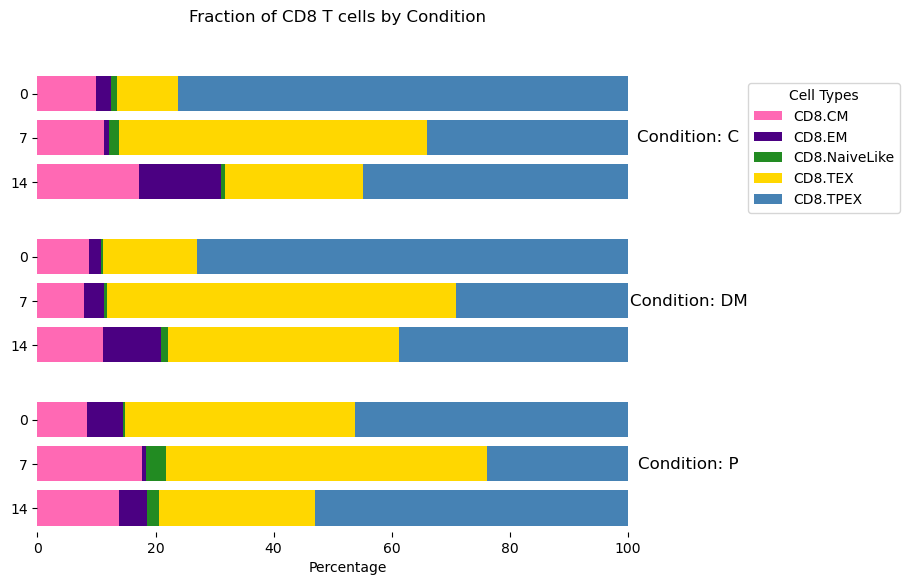

In [438]:
stacked_barplot(adata_nona)

In [427]:
sum(adata.obs.Tcell_subtype == 'CD8.TPEX')

2312

In [439]:
s = adata[adata.obs.condition == 'C',:]
CD4_only = list(map(lambda subtype: isinstance(subtype, str) and 'CD4' in subtype, s.obs.Tcell_subtype))
s2 = s[CD4_only,:]
unq = np.unique(s2.obs.Tcell_subtype)

subset[subset.obs.day == celltype,:]

# values = s[s.obs.day == 'd0',:].obs.Tcell_subtype.value_counts()

# values

AttributeError: 'DataFrame' object has no attribute 'condition'

In [ ]:
for i, day in days:
    day_subset = s2[s2.obs.day == day,:]
    

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,outlier,most_likely_hypothesis,cluster_feature,...,singlet_hypothesis_probability,doublet_hypothesis_probability,Classification,dataset,is_tcell,Tcell_subtype,Tcell_subtypes,leiden,condition,day
AAACCTGAGAACTCGG-1_0,3021,8.013674,10380.0,9.247732,113.0,4.736198,1.088632,False,1.0,0.0,...,0.995790,0.001040,d0_C,0,Pure,CD4.Th17,CD4.Th17,0,C,d0
AAACCTGTCGTTTAGG-1_0,3122,8.046549,10219.0,9.232101,7.0,2.079442,0.068500,False,1.0,0.0,...,0.987900,0.003485,d0_C,0,Pure,CD4.Th17,CD4.Th17,3,C,d0
AAAGCAATCTCCGGTT-1_0,1940,7.570959,4244.0,8.353498,62.0,4.143135,1.460886,False,1.0,0.0,...,0.981884,0.005985,d0_C,0,Pure,CD4.Tfh,CD4.Tfh,0,C,d0
AAATGCCGTCGACTAT-1_0,3154,8.056744,11035.0,9.308918,91.0,4.521789,0.824649,False,1.0,0.0,...,0.989632,0.001435,d0_C,0,Pure,CD4.Th17,CD4.Th17,3,C,d0
AACACGTAGAATTGTG-1_0,2625,7.873217,7995.0,8.986696,228.0,5.433722,2.851782,False,1.0,0.0,...,0.993263,0.005433,d0_C,0,Pure,CD4.Th17,CD4.Th17,0,C,d0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGCTACCGTCTCCACT-1_8,468,6.150603,588.0,6.378426,22.0,3.135494,3.741496,False,1.0,0.0,...,0.803715,0.190956,d14_C4_TIL,8,Pure,CD4.Tfh,CD4.Tfh,6,C,d14
TGGACGCCAGCTCGAC-1_8,1121,7.022868,1829.0,7.512071,81.0,4.406719,4.428650,False,1.0,0.0,...,0.627181,0.371606,d14_C4_TIL,8,Pure,CD4.Th17,CD4.Th17,1,C,d14
TGTGGTACATATACGC-1_8,464,6.142037,575.0,6.356108,19.0,2.995732,3.304348,False,1.0,0.0,...,0.864053,0.128366,d14_C4_TIL,8,Pure,CD4.Tfh,CD4.Tfh,0,C,d14
TTGAACGCACAGGAGT-1_8,579,6.363028,830.0,6.722630,23.0,3.178054,2.771084,False,1.0,0.0,...,0.626606,0.371265,d14_C4_TIL,8,Pure,CD4.NaiveLike,CD4.NaiveLike,6,C,d14


In [89]:
CD4_only = list(map(lambda subtype: isinstance(subtype, str) and 'CD4' in subtype, adata.obs.Tcell_subtype))
adata[CD4_only,:].obs
# 'CD4' in adata.obs.Tcell_subtype

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,outlier,most_likely_hypothesis,cluster_feature,...,singlet_hypothesis_probability,doublet_hypothesis_probability,Classification,dataset,is_tcell,Tcell_subtype,Tcell_subtypes,leiden,condition,day
AAACCTGAGAACTCGG-1_0,3021,8.013674,10380.0,9.247732,113.0,4.736198,1.088632,False,1.0,0.0,...,0.995790,0.001040,d0_C,0,Pure,CD4.Th17,CD4.Th17,0,C,d0
AAACCTGTCCTTGCCA-1_0,3206,8.073091,9150.0,9.121618,92.0,4.532599,1.005465,False,1.0,0.0,...,0.974765,0.019075,d0_DM,0,Pure,CD4.Th17,CD4.Th17,0,DM,d0
AAACCTGTCGTTTAGG-1_0,3122,8.046549,10219.0,9.232101,7.0,2.079442,0.068500,False,1.0,0.0,...,0.987900,0.003485,d0_C,0,Pure,CD4.Th17,CD4.Th17,3,C,d0
AAACCTGTCTCTTGAT-1_0,2895,7.971086,9365.0,9.144841,127.0,4.852030,1.356113,False,1.0,0.0,...,0.969311,0.030683,d0_P,0,Pure,CD4.CTL_Exh,CD4.CTL_Exh,1,P,d0
AAAGCAATCGAACTGT-1_0,2148,7.672758,5812.0,8.667852,174.0,5.164786,2.993806,False,1.0,0.0,...,0.967097,0.032903,d0_P,0,Pure,CD4.NaiveLike,CD4.NaiveLike,0,P,d0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGAACGCACAGGAGT-1_8,579,6.363028,830.0,6.722630,23.0,3.178054,2.771084,False,1.0,0.0,...,0.626606,0.371265,d14_C4_TIL,8,Pure,CD4.NaiveLike,CD4.NaiveLike,6,C,d14
TTGAACGCATCGTCGG-1_8,607,6.410175,813.0,6.701961,12.0,2.564949,1.476015,False,1.0,0.0,...,0.752295,0.245871,d14_DM4_TIL,8,Pure,CD4.Treg,CD4.Treg,1,DM,d14
TTGAACGGTACGAAAT-1_8,918,6.823286,1476.0,7.297768,42.0,3.761200,2.845529,False,1.0,0.0,...,0.788466,0.207129,d14_DM4_TIL,8,Pure,CD4.Treg,CD4.Treg,6,DM,d14
TTGGAACGTTAAGTAG-1_8,773,6.651572,1102.0,7.005789,40.0,3.713572,3.629764,False,1.0,0.0,...,0.678501,0.317030,d14_P4_TIL,8,Pure,CD4.Tfh,CD4.Tfh,1,P,d14


In [76]:
adata.obs.Tcell_subtype.str

In [ ]:
conditions2 = np.unique(adata.obs.condition.values)
days2 = np.unique(adata.obs.day)

x = np.arange(len(conditions2) * len(days2))
width = 0.8
bottom = np.zeros(len(x))

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [55]:
np.unique(adata.obs.condition.values)

array(['C', 'DM', 'P'], dtype=object)

In [49]:
add_DaysConds_to_adata(adata, days, conditions)

In [50]:
adata.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,outlier,most_likely_hypothesis,cluster_feature,...,singlet_hypothesis_probability,doublet_hypothesis_probability,Classification,dataset,is_tcell,Tcell_subtype,Tcell_subtypes,leiden,condition,day
AAACCTGAGAACTCGG-1_0,3021,8.013674,10380.0,9.247732,113.0,4.736198,1.088632,False,1.0,0.0,...,0.995790,0.001040,d0_C,0,Pure,CD4.Th17,CD4.Th17,0,C,d0
AAACCTGAGACAGGCT-1_0,5322,8.579792,30008.0,10.309253,297.0,5.697093,0.989736,False,1.0,0.0,...,0.929500,0.070500,d0_P,0,Pure,NaN,NaN,2,P,d0
AAACCTGAGCCGTCGT-1_0,2038,7.620215,5278.0,8.571492,94.0,4.553877,1.780978,False,1.0,0.0,...,0.957746,0.037977,d0_C,0,Pure,NaN,NaN,0,C,d0
AAACCTGAGCGTTTAC-1_0,3495,8.159375,13223.0,9.489789,113.0,4.736198,0.854572,False,1.0,0.0,...,0.985589,0.000878,d0_C,0,Pure,CD8.TEX,CD8.TEX,3,C,d0
AAACCTGAGGCAGTCA-1_0,2942,7.987185,9689.0,9.178850,191.0,5.257495,1.971308,False,1.0,0.0,...,0.975334,0.001866,d0_DM,0,Pure,NaN,NaN,0,DM,d0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCAAAGTC-1_8,668,6.505784,864.0,6.762730,40.0,3.713572,4.629630,False,1.0,0.0,...,0.875772,0.107442,d14_C4_TIL,8,Pure,CD4.Treg,CD4.Treg,1,C,d14
TTTGTCAAGCGATTCT-1_8,967,6.875232,1460.0,7.286876,49.0,3.912023,3.356164,False,1.0,0.0,...,0.831875,0.161648,d14_DM4_TIL,8,Pure,NaN,NaN,1,DM,d14
TTTGTCAAGTCGATAA-1_8,906,6.810142,1421.0,7.259820,33.0,3.526361,2.322308,False,1.0,0.0,...,0.771789,0.219692,d14_DM4_TIL,8,Pure,CD8.TEX,CD8.TEX,4,DM,d14
TTTGTCATCACGAAGG-1_8,1097,7.001246,1814.0,7.503841,82.0,4.418840,4.520397,False,1.0,0.0,...,0.861860,0.136772,d14_DM4_TIL,8,Pure,CD8.TPEX,CD8.TPEX,0,DM,d14
